# TIME SERIES FORECASTING

## Import libraries

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
from pickle import dump

## Import data

In [99]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
total_data= pd.read_csv(url)

# Save Data
total_data.to_csv("/workspaces/TIME_SERIES_FORECASTING/data/raw/sales.csv", index = False)

In [100]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [101]:
total_data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [102]:
# turn format date into %Y/%m/%d

total_data["date"] = pd.to_datetime(total_data["date"]).dt.date
total_data.head(2)

,date,sales
0,2022-09-03,55.292157
1,2022-09-04,53.803211


In [103]:
# Turn date column into index
total_data.set_index("date", inplace=True)
total_data.head()

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


In [104]:
# Turn into a serie 
ts = total_data["sales"]
ts

date
2022-09-03      55.292157
2022-09-04      53.803211
2022-09-05      58.141693
2022-09-06      64.530899
2022-09-07      66.013633
                 ...     
2023-08-30     989.600354
2023-08-31     994.987326
2023-09-01     995.814415
2023-09-02     997.350214
2023-09-03    1000.482785
Name: sales, Length: 366, dtype: float64

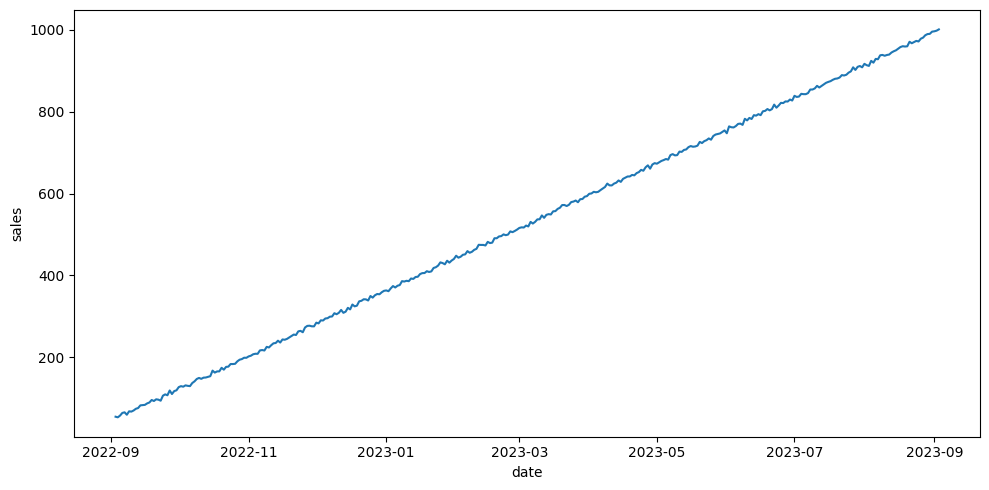

In [105]:
# Plot sales

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)

plt.tight_layout()

plt.show()

We can observe the following in this plot:

1)  Trend: An upward trend is apparent, indicating that sales have increased over time.

2)  Seasonality: There is not seasonality in the data.

3)  Variability: There are not points of variability in the time series.

4)  Outliers: After studying the trend and seasonality of the time series, no outliers are observed.

5) Inflection points: Ther are not inflection points.

## Decomposition of the serie

In [106]:
decomposition = seasonal_decompose(ts, period = 12)
decomposition

### Trend analysis

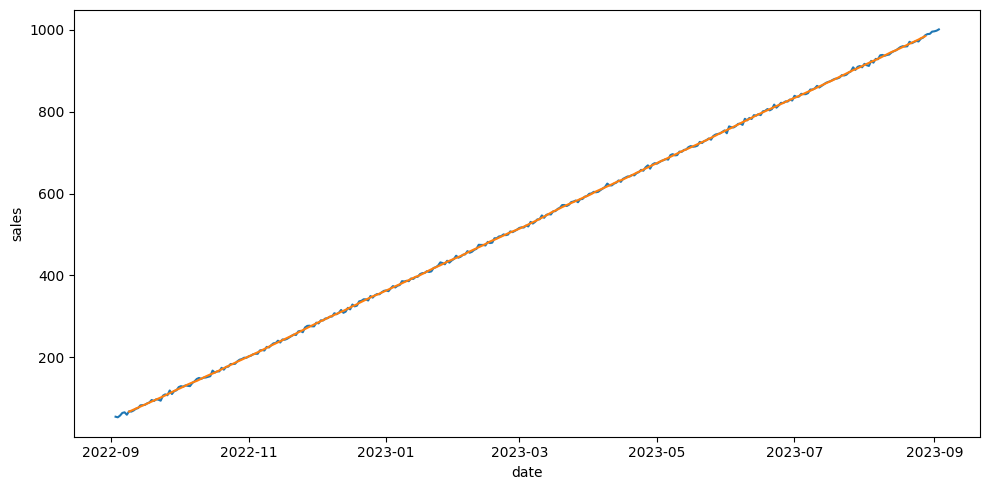

In [107]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

We can confirm a clear positive trend over time

### Seasonality analysis

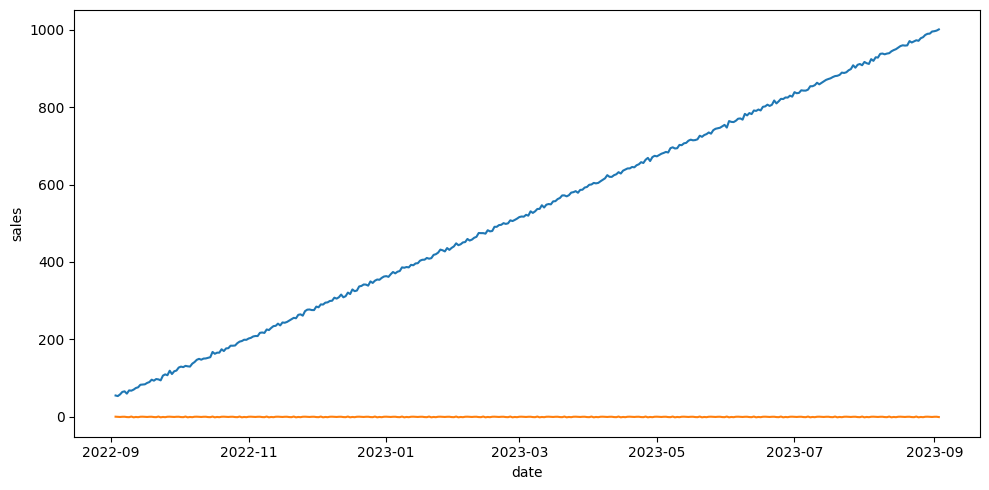

In [108]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

We can confirm there is no stationarity

### Dickey-Fuller test

Null Hypothesis (H0): the series is non-stationary

Alternative Hypothesis (H1): the series is stationary

In [109]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Here we can see that the p-value is greater than 0.05, indicating that we fail to reject our null hypothesis. Therefore, based on this result, we consider this series as non-stationary, as observed."

### Analysis of variability

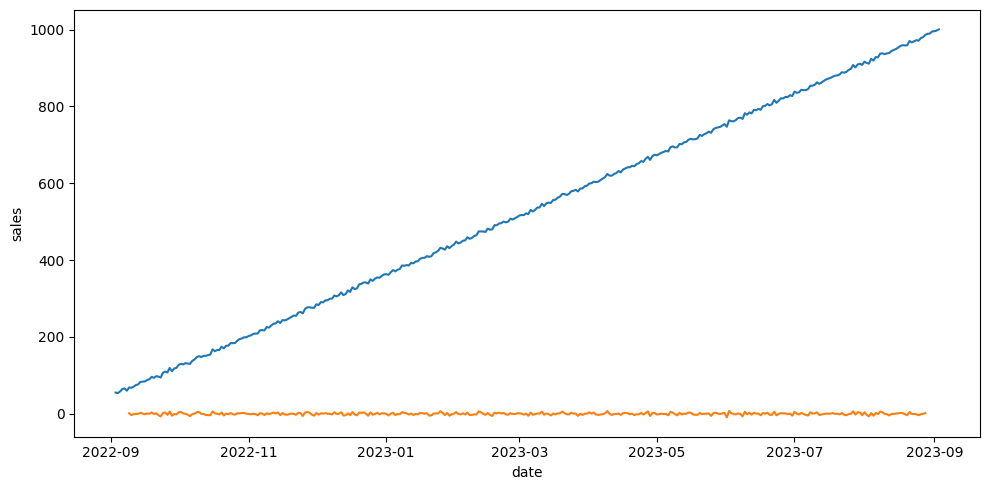

In [110]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

We can confirm that there are no residuals in the period studied.

### Autocorrelation analysis

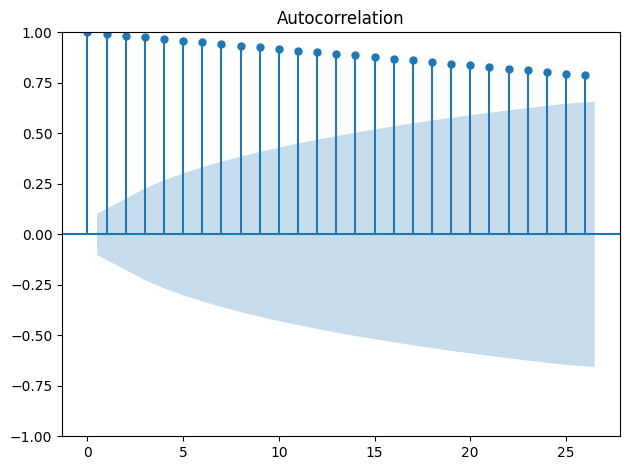

In [111]:
plot_acf(ts)

plt.tight_layout()

plt.show()

There exists a strong correlation among the data points and their lagged versions, which diminishes as time passes.

With this, we can conclude the following points:

1) What is the time series pattern?
-   Days.

2)  What is the trend?
-   It exhibits a non-linear growth trend.

3)  Is it stationary?
-   It is not stationary.

4)  Does it exhibit variability or presence of noise?
-   There is no variability.

In [112]:
# transform the series into stationary

ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

## ARIMA Model

### Stationary

In [113]:
# Create model stationary

model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1847.120, Time=2.05 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1972.854, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2209.657, Time=0.05 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1845.127, Time=1.16 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=1843.049, Time=0.49 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=1.82 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1843.587, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1841.533, Time=0.40 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=1843.434, Time=1.75 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=1.73 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1839.553, Time=0.29 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1841.456, Time=0.77 sec
 ARIM

In [114]:
# Displaying model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -915.776
Date:                Sat, 23 Dec 2023   AIC                           1839.553
Time:                        17:54:24   BIC                           1855.152
Sample:                    09-04-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [115]:
# Save model
dump(model, open("/workspaces/TIME_SERIES_FORECASTING/models/Arima_model_stationary.pk", "wb"))

In [116]:
# Predict 30 days of sales
forecast = model.predict(30)
forecast

2023-09-04    1.675366
2023-09-05    2.673520
2023-09-06    2.591621
2023-09-07    2.598341
2023-09-08    2.597789
2023-09-09    2.597834
2023-09-10    2.597831
2023-09-11    2.597831
2023-09-12    2.597831
2023-09-13    2.597831
2023-09-14    2.597831
2023-09-15    2.597831
2023-09-16    2.597831
2023-09-17    2.597831
2023-09-18    2.597831
2023-09-19    2.597831
2023-09-20    2.597831
2023-09-21    2.597831
2023-09-22    2.597831
2023-09-23    2.597831
2023-09-24    2.597831
2023-09-25    2.597831
2023-09-26    2.597831
2023-09-27    2.597831
2023-09-28    2.597831
2023-09-29    2.597831
2023-09-30    2.597831
2023-10-01    2.597831
2023-10-02    2.597831
2023-10-03    2.597831
Freq: D, dtype: float64

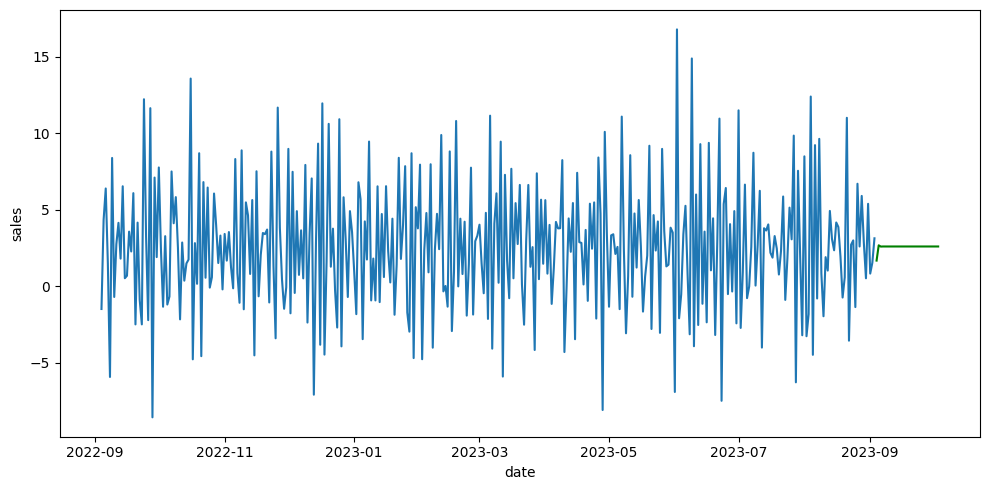

In [117]:
# Plot sales with prediction
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

We observed that our prediction didn't work when making our data stationary, so we need to reapply the model using non-stationary data.

### Non-stationary

In [118]:
# Create model non-stationary
model = auto_arima(ts, seasonal = False, trace = True, m = 12)

/home/vscode/.local/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.274, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.706 seconds


In [119]:
# Displaying model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Sat, 23 Dec 2023   AIC                           1839.552
Time:                        17:54:27   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
# Save model
dump(model, open("/workspaces/TIME_SERIES_FORECASTING/models/Arima_model_non_stationary.pk", "wb"))

In [121]:
# Predict 30 days of sales
forecast = model.predict(30)
forecast

2023-09-04    1002.158148
2023-09-05    1004.831669
2023-09-06    1007.423289
2023-09-07    1010.021630
2023-09-08    1012.619419
2023-09-09    1015.217254
2023-09-10    1017.815084
2023-09-11    1020.412915
2023-09-12    1023.010746
2023-09-13    1025.608577
2023-09-14    1028.206409
2023-09-15    1030.804240
2023-09-16    1033.402071
2023-09-17    1035.999902
2023-09-18    1038.597733
2023-09-19    1041.195564
2023-09-20    1043.793395
2023-09-21    1046.391226
2023-09-22    1048.989057
2023-09-23    1051.586888
2023-09-24    1054.184719
2023-09-25    1056.782550
2023-09-26    1059.380381
2023-09-27    1061.978212
2023-09-28    1064.576043
2023-09-29    1067.173874
2023-09-30    1069.771705
2023-10-01    1072.369536
2023-10-02    1074.967367
2023-10-03    1077.565198
Freq: D, dtype: float64

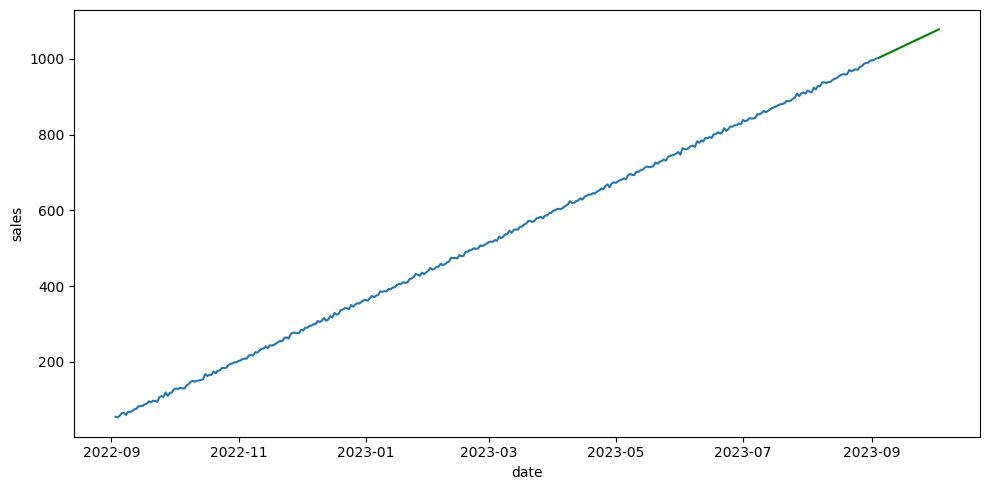

In [123]:
# Plot sales with prediction
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

We can conclude that the ARIMA model performs efficiently with non-stationary data.